In [3]:
from prophet import Prophet
import itertools
from prophet.diagnostics import cross_validation, performance_metrics
import plotly.offline as py
import matplotlib as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import holidays
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Defining training and test
training_upto = 2020
forecast_upto = (2023-training_upto-1)*12 +3

In [5]:
# Getting Holidays
holiday = pd.DataFrame([])
for date, name in sorted(holidays.country_holidays('GB', subdiv='England', years=[2012, 2013, 2014, 2015, 2016, 2017, 2018,2019,2020,2021, 2022, 2023, 2024]).items()):
    holiday= pd.concat([holiday, pd.DataFrame({'ds': date, 'holiday': "England-Holidays"}, index=[0])], ignore_index=True)

holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

## Prediction Whole of Barnet

In [6]:
# Read data, get dataframe with crimes/month
monthly_grouped_df = pd.read_csv(r'.\\Datasets\\Population\\filtered_df_utility_cols.csv')
monthly_grouped_df= monthly_grouped_df.sort_values(['Year','Month num'],ascending=False).groupby(['Year', 'Month num'])['Crime type'].count()
monthly_grouped_df = monthly_grouped_df.to_frame()


# Rename columns, select rows with data and set datetime index
monthly_grouped_df = monthly_grouped_df.rename(columns = {'Month num':'y'})
monthly_grouped_df['day'] = 1
monthly_grouped_df = monthly_grouped_df.reset_index()
monthly_grouped_df = monthly_grouped_df.rename(columns={'Month num': 'month', 'Year': 'year'})
monthly_grouped_df['ds'] = pd.to_datetime(monthly_grouped_df[['year', 'month', 'day']])
monthly_grouped_df['y'] = monthly_grouped_df['Crime type']
monthly_grouped_df['covid']  = 0
monthly_grouped_df['covid'][((monthly_grouped_df['year']==2020) & (monthly_grouped_df['month']>2)) | ((monthly_grouped_df['year']==2021)& (monthly_grouped_df['month']<6))]

# Divide test and train data
train_data = monthly_grouped_df[monthly_grouped_df['year']<(training_upto+1)]
test_data = monthly_grouped_df[(monthly_grouped_df['year']>training_upto)]

### Hyper-parameter tuning

In [7]:
# Defining the parameters & values to be tuned
param_grid = { 
    'seasonality_mode':('multiplicative','additive'), 
    'changepoint_prior_scale': [0.5, 0.1, 1,],
    'seasonality_prior_scale': [0.5, 0.1, 1],
    'holidays_prior_scale':[1, 10, 25, 50],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
maes = []  # Store the RMSEs for each params here

cutoffs = pd.date_range(start='2015-01-01', end='2021-12-01', freq='2MS')

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params, holidays= holiday).fit(monthly_grouped_df)  # Fit model with given params
    df_cv = cross_validation(m, cutoffs=cutoffs, horizon='365 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    maes.append(df_p['mae'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['mae'] = maes
print("Mean absolute error: ", np.argmin(maes))
best_params = all_params[np.argmin(maes)]
print("Best parameters", best_params)

20:15:07 - cmdstanpy - INFO - Chain [1] start processing
20:15:08 - cmdstanpy - INFO - Chain [1] done processing
20:15:18 - cmdstanpy - INFO - Chain [1] start processing
20:15:18 - cmdstanpy - INFO - Chain [1] done processing
20:15:27 - cmdstanpy - INFO - Chain [1] start processing
20:15:27 - cmdstanpy - INFO - Chain [1] done processing
20:15:39 - cmdstanpy - INFO - Chain [1] start processing
20:15:39 - cmdstanpy - INFO - Chain [1] done processing
20:15:52 - cmdstanpy - INFO - Chain [1] start processing
20:15:52 - cmdstanpy - INFO - Chain [1] done processing
20:16:05 - cmdstanpy - INFO - Chain [1] start processing
20:16:05 - cmdstanpy - INFO - Chain [1] done processing
20:16:18 - cmdstanpy - INFO - Chain [1] start processing
20:16:18 - cmdstanpy - INFO - Chain [1] done processing
20:16:29 - cmdstanpy - INFO - Chain [1] start processing
20:16:29 - cmdstanpy - INFO - Chain [1] done processing
20:16:41 - cmdstanpy - INFO - Chain [1] start processing
20:16:41 - cmdstanpy - INFO - Chain [1]

KeyboardInterrupt: 

20:19:53 - cmdstanpy - INFO - Chain [1] start processing
20:19:53 - cmdstanpy - INFO - Chain [1] done processing


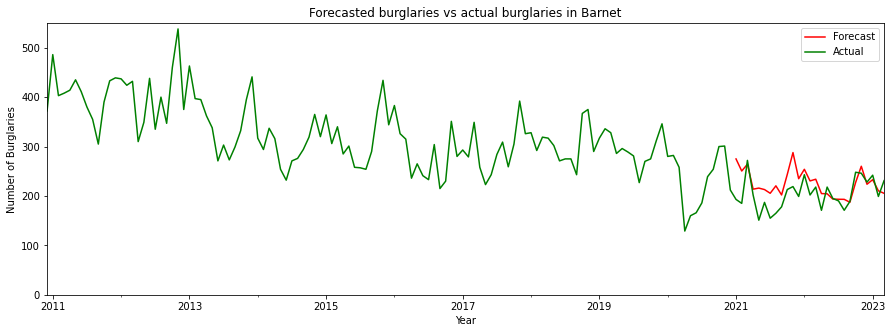

MAE 27.395094502580513
R2 -0.39598877558656076


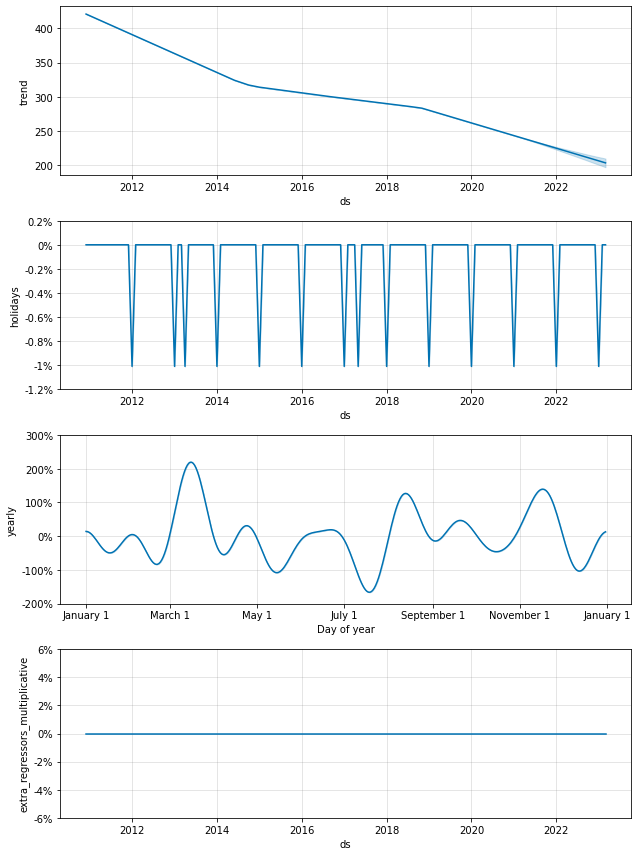

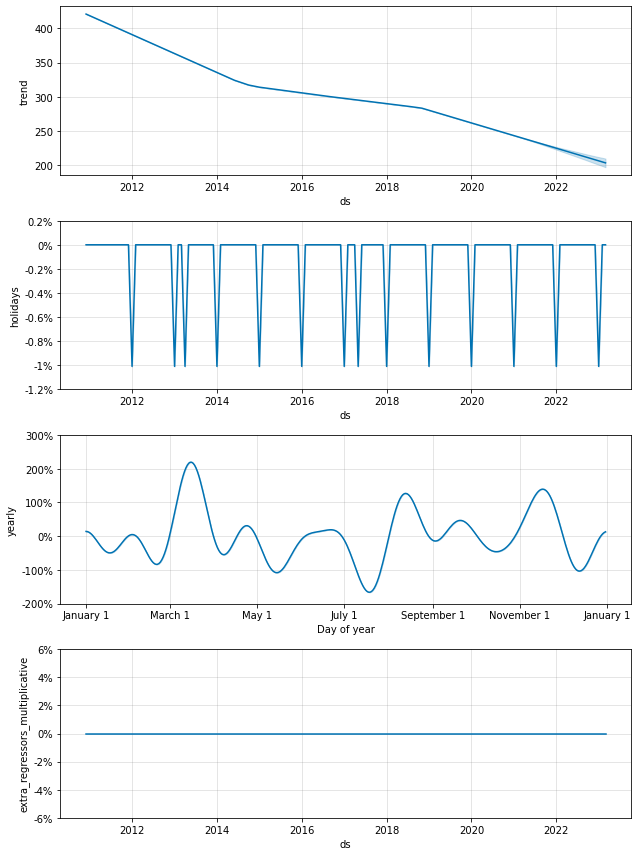

In [8]:
# Train the model with the best parameters and forecast
best_model = Prophet(seasonality_mode= 'multiplicative', changepoint_prior_scale= 0.1, seasonality_prior_scale= 1, holidays_prior_scale= 50, holidays= holiday)
best_model.add_regressor('covid')
best_model.fit(train_data)
future_dates = best_model.make_future_dataframe(periods=forecast_upto, freq='MS')
future_dates['covid'] = 0
forecast = best_model.predict(future_dates)

# Plot predictions
f, ax = plt.subplots(figsize=(14,5))
f.set_figheight(5)
f.set_figwidth(15)
forecast[-forecast_upto:].plot(kind='line',x='ds', y='yhat', color='red', label='Forecast', ax=ax)
monthly_grouped_df.plot(kind='line',x='ds',y='y', color='green',label='Actual', ax=ax)
plt.title('Forecasted burglaries vs actual burglaries in Barnet')
plt.xlabel("Year")
plt.ylabel("Number of Burglaries")
plt.ylim(0,550)
plt.show()

print("MAE", mean_absolute_error(test_data['y'], forecast['yhat'][-forecast_upto:]))
print("R2", r2_score(test_data['y'], forecast['yhat'][-forecast_upto:]))

best_model.plot_components(forecast)

## Prediction per ward

In [9]:
# Create the dataframe
file =  pd.read_csv(r'.\\Datasets\\Population\\filtered_df_utility_cols.csv')
df_per_ward= file.sort_values(['Year','Month num'],ascending=False).groupby(['Ward', 'Year', 'Month num']).count()

# Create a dataframe with the wanted dates
dates = pd.date_range(start='12/1/2010', end='3/1/2023', freq='MS').to_frame()
df_per_ward = df_per_ward.reset_index()

# Specify columns: ds, y, Date, covid
df_per_ward['day'] = 1
df_per_ward = df_per_ward.reset_index()
df_per_ward['y'] = df_per_ward['Crime type']
df_per_ward = df_per_ward.rename(columns={'Month num': 'month', 'Year': 'year'})
df_per_ward['ds'] = pd.to_datetime(df_per_ward[['year', 'month', 'day']])
df_per_ward['Date'] = df_per_ward['ds']
df_per_ward['covid']  = 0
df_per_ward['covid'][((df_per_ward['year']==2020) & (df_per_ward['month']>2)) | ((df_per_ward['year']==2021)& (df_per_ward['month']<6))]
dates['Date'] = dates[0]
dates = dates[['Date']]

C:\Users\Rafi\AppData\Local\Temp\ipykernel_1972\3759057798.py:29: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.

20:19:54 - cmdstanpy - INFO - Chain [1] start processing
20:19:54 - cmdstanpy - INFO - Chain [1] done processing


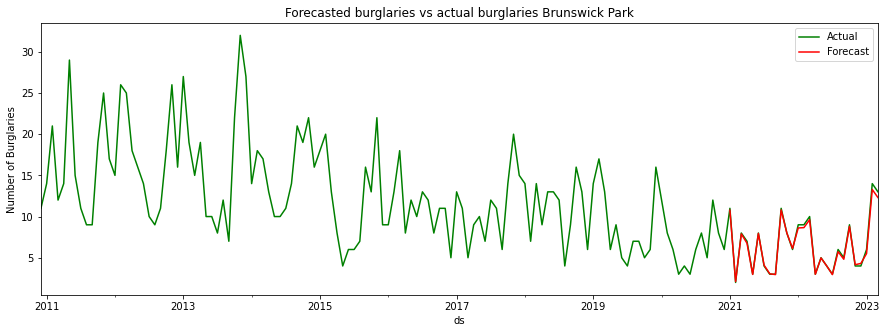

C:\Users\Rafi\AppData\Local\Temp\ipykernel_1972\3759057798.py:29: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.

20:19:55 - cmdstanpy - INFO - Chain [1] start processing
20:19:55 - cmdstanpy - INFO - Chain [1] done processing


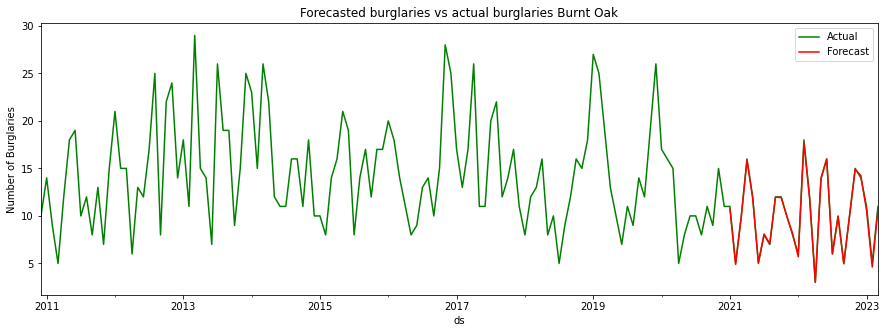

C:\Users\Rafi\AppData\Local\Temp\ipykernel_1972\3759057798.py:29: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.

20:19:55 - cmdstanpy - INFO - Chain [1] start processing
20:19:55 - cmdstanpy - INFO - Chain [1] done processing


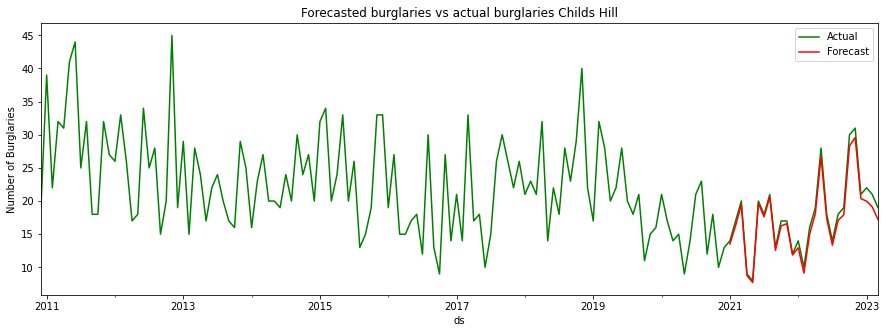

C:\Users\Rafi\AppData\Local\Temp\ipykernel_1972\3759057798.py:29: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.

20:19:56 - cmdstanpy - INFO - Chain [1] start processing
20:19:56 - cmdstanpy - INFO - Chain [1] done processing


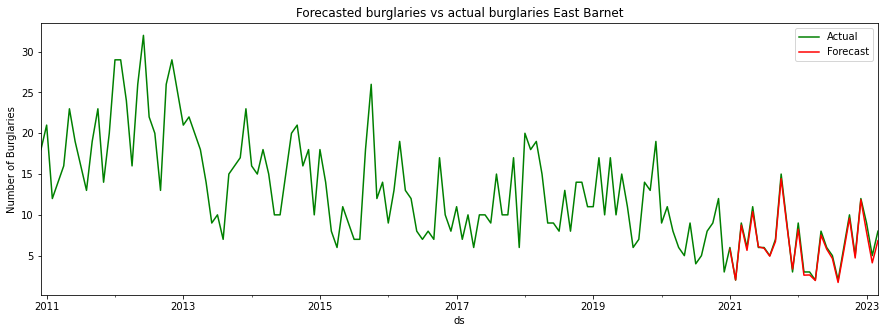

C:\Users\Rafi\AppData\Local\Temp\ipykernel_1972\3759057798.py:29: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.

20:19:56 - cmdstanpy - INFO - Chain [1] start processing
20:19:56 - cmdstanpy - INFO - Chain [1] done processing


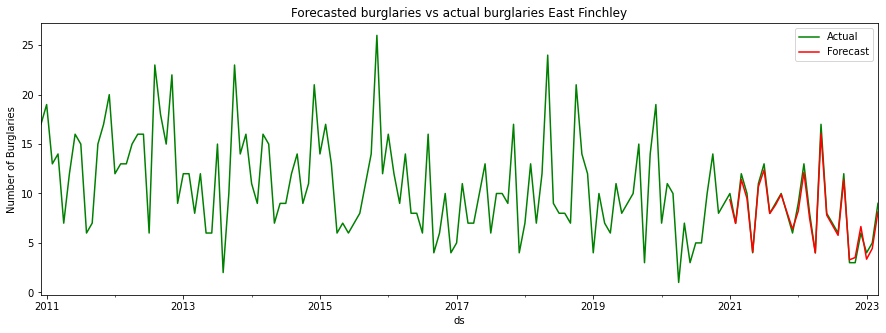

C:\Users\Rafi\AppData\Local\Temp\ipykernel_1972\3759057798.py:29: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.

20:19:57 - cmdstanpy - INFO - Chain [1] start processing
20:19:57 - cmdstanpy - INFO - Chain [1] done processing


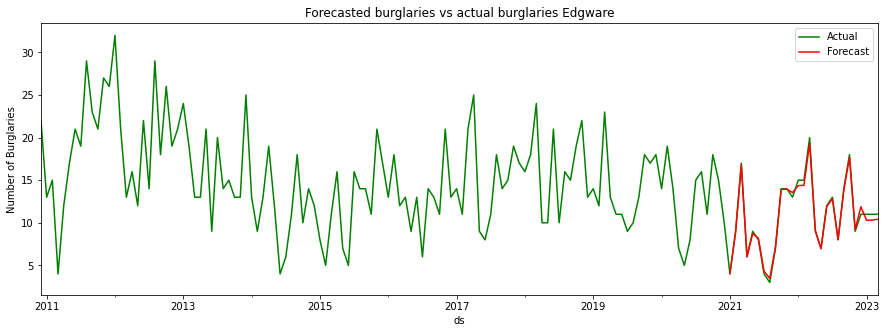

C:\Users\Rafi\AppData\Local\Temp\ipykernel_1972\3759057798.py:29: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.

20:19:57 - cmdstanpy - INFO - Chain [1] start processing
20:19:57 - cmdstanpy - INFO - Chain [1] done processing


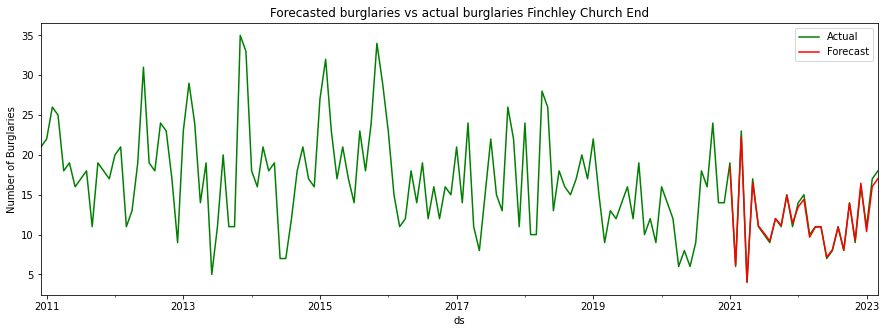

C:\Users\Rafi\AppData\Local\Temp\ipykernel_1972\3759057798.py:29: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.

20:19:58 - cmdstanpy - INFO - Chain [1] start processing
20:19:58 - cmdstanpy - INFO - Chain [1] done processing


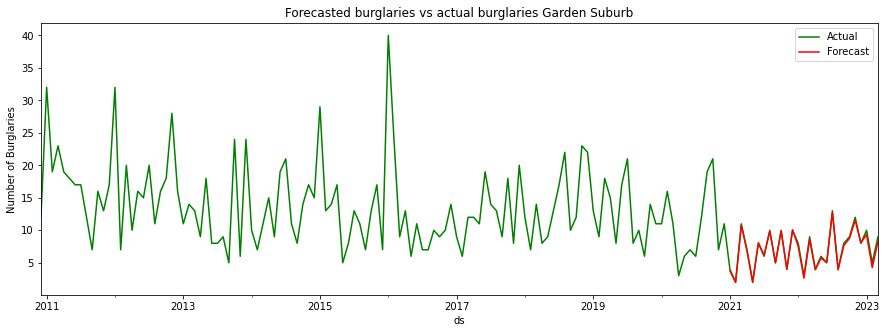

C:\Users\Rafi\AppData\Local\Temp\ipykernel_1972\3759057798.py:29: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.

20:19:58 - cmdstanpy - INFO - Chain [1] start processing
20:19:58 - cmdstanpy - INFO - Chain [1] done processing


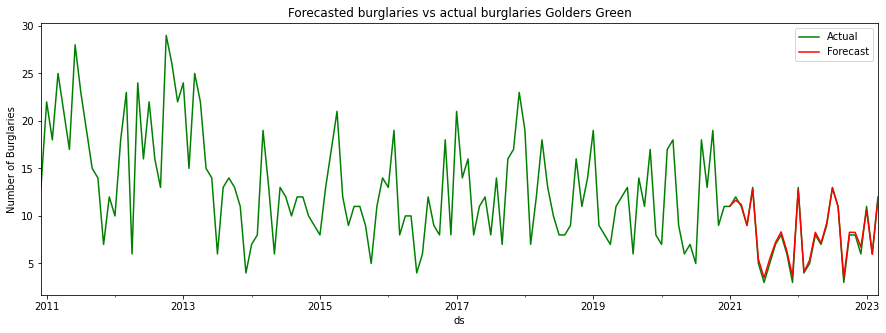

C:\Users\Rafi\AppData\Local\Temp\ipykernel_1972\3759057798.py:29: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.

20:19:59 - cmdstanpy - INFO - Chain [1] start processing
20:19:59 - cmdstanpy - INFO - Chain [1] done processing


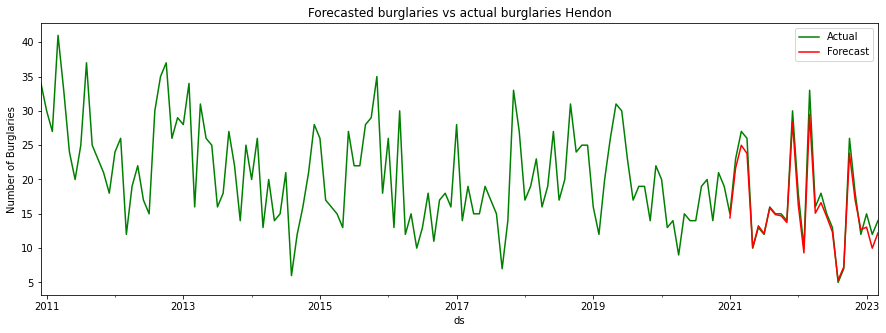

C:\Users\Rafi\AppData\Local\Temp\ipykernel_1972\3759057798.py:29: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.

20:19:59 - cmdstanpy - INFO - Chain [1] start processing
20:19:59 - cmdstanpy - INFO - Chain [1] done processing


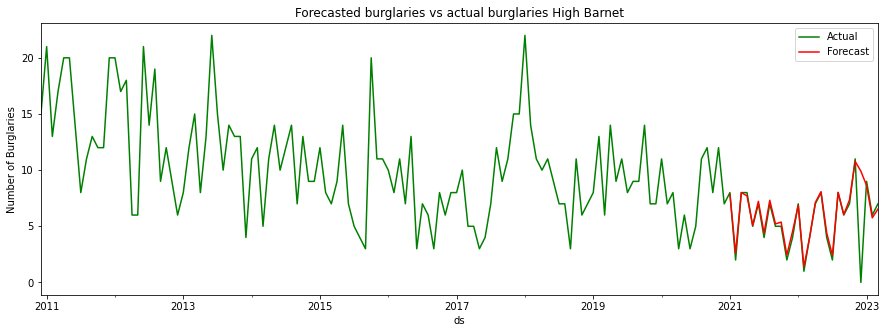

C:\Users\Rafi\AppData\Local\Temp\ipykernel_1972\3759057798.py:29: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.

20:20:00 - cmdstanpy - INFO - Chain [1] start processing
20:20:00 - cmdstanpy - INFO - Chain [1] done processing


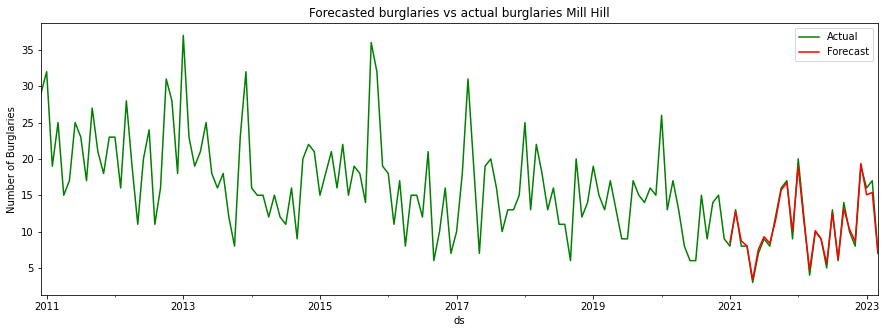

C:\Users\Rafi\AppData\Local\Temp\ipykernel_1972\3759057798.py:29: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.

20:20:00 - cmdstanpy - INFO - Chain [1] start processing
20:20:00 - cmdstanpy - INFO - Chain [1] done processing


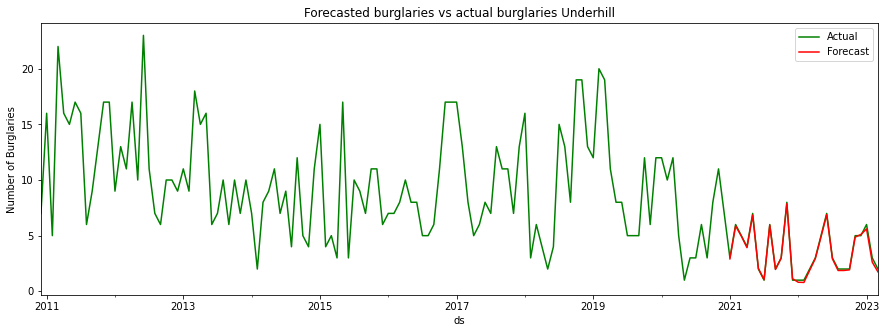

C:\Users\Rafi\AppData\Local\Temp\ipykernel_1972\3759057798.py:29: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.

20:20:01 - cmdstanpy - INFO - Chain [1] start processing
20:20:01 - cmdstanpy - INFO - Chain [1] done processing


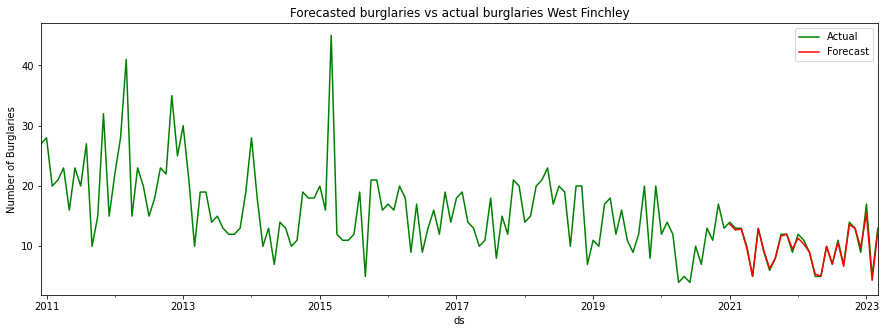

C:\Users\Rafi\AppData\Local\Temp\ipykernel_1972\3759057798.py:29: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.

20:20:01 - cmdstanpy - INFO - Chain [1] start processing
20:20:01 - cmdstanpy - INFO - Chain [1] done processing


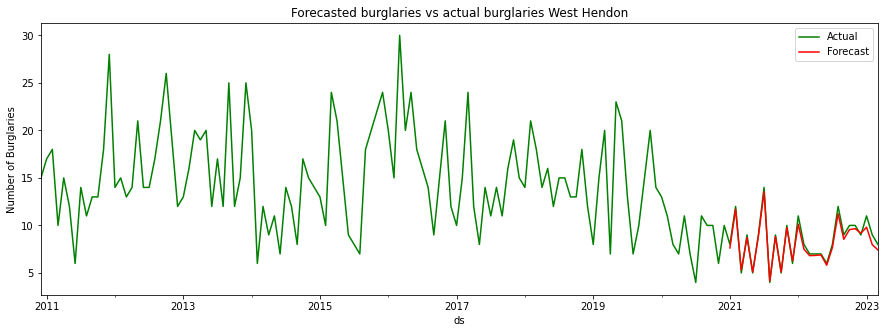

C:\Users\Rafi\AppData\Local\Temp\ipykernel_1972\3759057798.py:29: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.

20:20:02 - cmdstanpy - INFO - Chain [1] start processing
20:20:02 - cmdstanpy - INFO - Chain [1] done processing


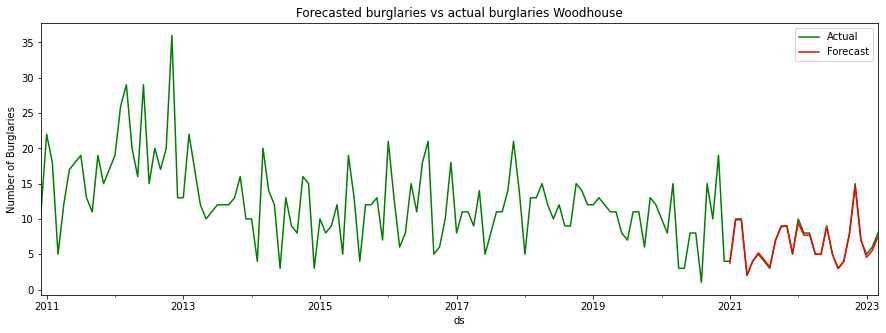

Mean MAE 0.39988774454294


In [10]:
# Create a dataframe with the wanted dates
dates = pd.date_range(start='12/1/2010', end='3/1/2023', freq='MS').to_frame()

# Specify columns: ds, y, Date
df_per_ward['day'] = 1
df_per_ward = df_per_ward.reset_index()
df_per_ward = df_per_ward.rename(columns={'Month num': 'month', 'Year': 'year'})
df_per_ward['ds'] = pd.to_datetime(df_per_ward[['year', 'month', 'day']])
df_per_ward['Date'] = df_per_ward['ds']
dates['Date'] = dates[0]
dates = dates[['Date']]

# Loop over wards
wards = ['Brunswick Park', 'Burnt Oak', 'Childs Hill', 'East Barnet',
       'East Finchley', 'Edgware', 'Finchley Church End', 'Garden Suburb',
       'Golders Green', 'Hendon', 'High Barnet', 'Mill Hill', 'Underhill',
       'West Finchley', 'West Hendon', 'Woodhouse']
mse = []
mae = []

for ward in wards: 
       # Select data of ward
       df_ward = df_per_ward[df_per_ward['Ward']==ward]
       df_ward = df_ward[['ds', 'Date', 'year', 'y', 'Population per square kilometre','covid']]
       # Merge with all dates to have a consistent dataframe
       df_ward = pd.merge(dates, df_ward, how="left", on='Date')
       df_ward['ds'] = df_ward['Date']
       df_ward['y'] = df_ward['y'].fillna(0)
       df_ward = df_ward.fillna(df_ward.mean())
       df_ward['year'] = pd.DatetimeIndex(df_ward['Date']).year
       train_ward = df_ward[df_ward['year']<(training_upto+1)]
       test_ward = df_ward[(df_ward['year']>training_upto)] 
       best_model = Prophet(seasonality_mode= 'additive', changepoint_prior_scale= 15, seasonality_prior_scale= 15, holidays_prior_scale= 30, holidays= holiday)
       best_model.add_regressor('Population per square kilometre')
       best_model.fit(train_ward)
       future_dates = best_model.make_future_dataframe(periods=forecast_upto, freq='MS')
       future_dates = pd.merge(future_dates, df_ward, how="left", on='ds')
       forecast = best_model.predict(future_dates[-forecast_upto:])
       mae.append(mean_absolute_error(test_ward['y'], forecast['yhat']))
       mse.append(mean_squared_error(test_ward['y'], forecast['yhat']))
       f, ax = plt.subplots(figsize=(14,5))
       f.set_figheight(5)
       ax.set_xlabel("Year")
       ax.set_ylabel("Number of Burglaries")
       f.set_figwidth(15)
       
       df_ward.plot(kind='line',x='ds',y='y', color='green',label='Actual', ax=ax)
       forecast[-forecast_upto:].plot(kind='line',x='ds', y='yhat', color='red', label='Forecast', ax=ax)
       title = 'Forecasted burglaries vs actual burglaries ' + ward
       plt.title(title)
       plt.show()

print("Mean MAE", np.mean(mae))
       

In [18]:
forecast[-forecast_upto:]

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,England-Holidays,England-Holidays_lower,England-Holidays_upper,Population per square kilometre,...,holidays,holidays_lower,holidays_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-01-01,12.117821,3.074332,4.446625,12.117821,12.155743,1.694174,1.694174,1.694174,-8.180897,...,1.694174,1.694174,1.694174,-1.902024,-1.902024,-1.902024,0.0,0.0,0.0,3.729074
1,2021-02-01,12.109615,9.158765,10.649765,12.009924,12.333784,0.000000,0.000000,0.000000,-2.425731,...,0.000000,0.000000,0.000000,0.172840,0.172840,0.172840,0.0,0.0,0.0,9.856724
2,2021-03-01,12.102204,9.131912,10.848243,11.798166,12.631288,0.000000,0.000000,0.000000,-2.425731,...,0.000000,0.000000,0.000000,0.213825,0.213825,0.213825,0.0,0.0,0.0,9.890298
3,2021-04-01,12.093998,1.145290,3.096543,11.551400,12.929489,0.000000,0.000000,0.000000,-10.099286,...,0.000000,0.000000,0.000000,0.050995,0.050995,0.050995,0.0,0.0,0.0,2.045707
4,2021-05-01,12.086057,2.914124,5.388887,11.254125,13.338757,0.000000,0.000000,0.000000,-8.180897,...,0.000000,0.000000,0.000000,0.089314,0.089314,0.089314,0.0,0.0,0.0,3.994474
5,2021-06-01,12.077851,3.810644,6.987611,10.914430,13.821020,0.000000,0.000000,0.000000,-7.221703,...,0.000000,0.000000,0.000000,0.346831,0.346831,0.346831,0.0,0.0,0.0,5.202980
6,2021-07-01,12.069910,2.508396,6.432338,10.432483,14.262476,0.000000,0.000000,0.000000,-8.180897,...,0.000000,0.000000,0.000000,0.343775,0.343775,0.343775,0.0,0.0,0.0,4.232788
7,2021-08-01,12.061705,1.090277,5.851206,10.031184,14.671969,0.000000,0.000000,0.000000,-9.140091,...,0.000000,0.000000,0.000000,0.251546,0.251546,0.251546,0.0,0.0,0.0,3.173160
8,2021-09-01,12.053499,4.293004,10.218385,9.563660,15.127839,0.000000,0.000000,0.000000,-5.303314,...,0.000000,0.000000,0.000000,0.176293,0.176293,0.176293,0.0,0.0,0.0,6.926478
9,2021-10-01,12.045558,5.755598,12.691206,9.009419,15.875967,0.000000,0.000000,0.000000,-3.384925,...,0.000000,0.000000,0.000000,0.192910,0.192910,0.192910,0.0,0.0,0.0,8.853543
